In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

In [3]:
#create kclub graph 
G = nx.karate_club_graph()
pos = nx.spring_layout(G)
global_nodelist = list(G.nodes())

#find modularity matrix of G
A = nx.to_numpy_array(G,nodelist=global_nodelist,weight = None)
k = np.array([np.sum(A,axis=0)])
m = np.sum(k)
global_B = A - (1/m)*(k.T@k)

#initialise data structures to store output
final_communities = [] #stores the list of final communities after all the splits
iter_tree_layers = {} #stores the subgraphs at each iteration/recursion depth
iter_tree_communities= {}#stores the subgraphs that trigger the base case

In [4]:
#recursive function to find communities based on modularity and store them as output
def split(G,node_list,depth = 0):
    #find the modularity sub matrix coresponding to the sub graph and find its eigen vectors and values
    B = global_B[np.ix_(node_list,node_list)]
    e,v = np.linalg.eig(B)
    
    #use the components of the eigen vector corresponding to the largest eigen value to split the graph into two sub graphs
    s = v[:,np.argmax(e)]
    n1 = []
    n2 = []
    for i in range(s.shape[0]):
        if s[i]<=0:
            n1.append(node_list[i])
        else:
            n2.append(node_list[i])
    g1 = G.subgraph(n1)
    g2 = G.subgraph(n2)
    
    #stores sub-graphs based on recursion depth ie number of iterations
    if depth in iter_tree_layers:
        iter_tree_layers[depth].append(node_list)
    else:
        iter_tree_layers[depth] = [node_list]
    #base cases to stop recursion
    #if largest eigen value is less than zero ie there is no optimal split to increase modularity
    if np.max(e)<=0:
        final_communities.append(node_list)
        if depth in iter_tree_communities:
            iter_tree_communities[depth].append(node_list)
        else:
            iter_tree_communities[depth] = [node_list]
        return
    #if either of the sub-graphs are empty 
    if len(n1) == 0 or len(n2) == 0 :
        final_communities.append(node_list)
        if depth in iter_tree_communities:
            iter_tree_communities[depth].append(node_list)
        else:
            iter_tree_communities[depth] = [node_list]
        return
    #recursion
    split(g1,n1,depth+1)
    split(g2,n2,depth+1)


In [5]:
split(G,global_nodelist)
print(final_communities)

[[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]]


In [6]:
#function to draw a given sub graph
def draw(sublist):
    n = len(sublist)
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0,1,n)]
    nx.draw_networkx_nodes(G,pos)
    for i in range(n):
        nx.draw_networkx_nodes(G,pos,nodelist = sublist[i], node_color = colors[i])
        nx.draw_networkx_labels(G,pos,{a:i for a in sublist[i]} )
    nx.draw_networkx_edges(G,pos)

C:\Users\ShankarSajith\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


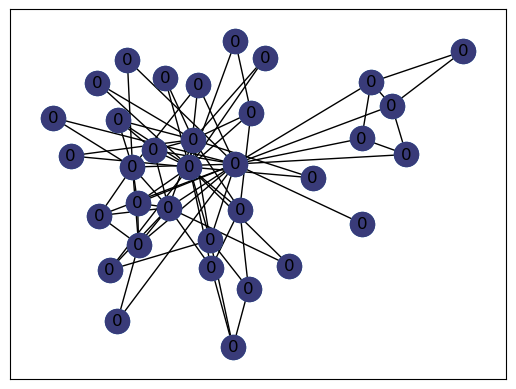

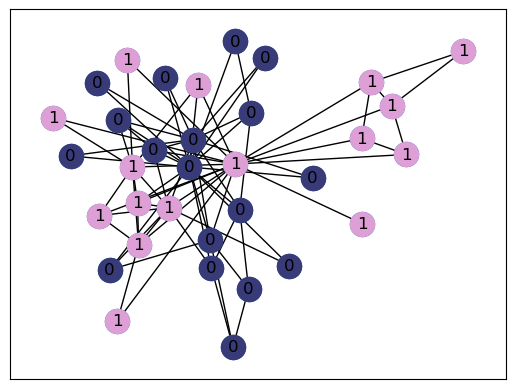

In [7]:
#includes subgraphs that trigger base case in all following iterations in iter_tree_layers
for key,val in sorted(iter_tree_layers.items()):
    newval = val
    for key2,val2 in sorted(iter_tree_communities.items()):
        if key>key2:
            newval = newval + val2
    iter_tree_layers[key] = newval
#print graphs at each iteration
for key,val in sorted(iter_tree_layers.items()):
    draw(val)
    plt.show()

In [8]:
#calculate node metrics
node_metrics = {a:{} for a in global_nodelist}

for key,val in sorted(iter_tree_layers.items()):
    for i in val:
        Ga = G.subgraph(i)
        d = nx.degree_centrality(Ga)
        b = nx.betweenness_centrality(Ga)
        cc = nx.closeness_centrality(Ga)
        c = nx.clustering(Ga)
        for j in i:
            node_metrics[j][key] = [d[j],b[j],cc[j],c[j]]

34


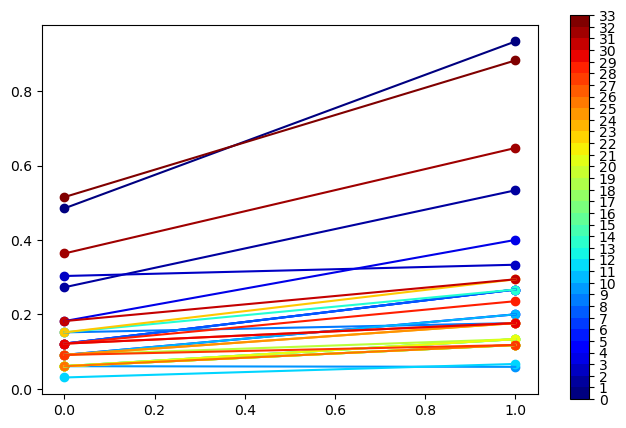

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0,1,34)]
print(len(colors))
for k,v in node_metrics.items():
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,0],color = colors[k])
    ax1.plot(depths,metrics[:,0],color = colors[k])

bounds = np.linspace(0, 33, 34)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', colors, cmap.N)
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
plt.show()



In [10]:
#most nodes degree centrality remains the same, the increase in degree centrality apprears to be proportional to inital 
#degree centrality

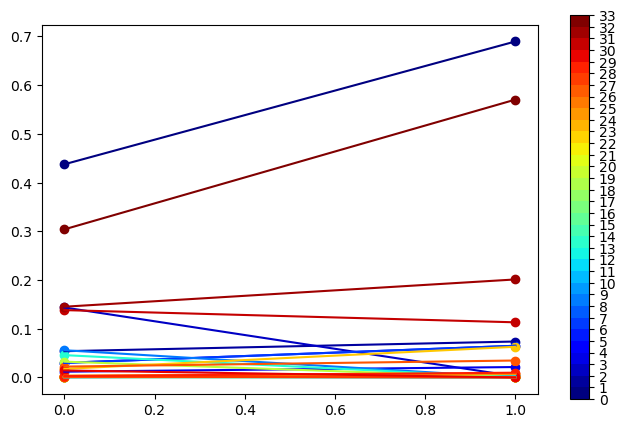

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
for k,v in node_metrics.items():
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,1],color = colors[k])
    ax1.plot(depths,metrics[:,1],color = colors[k])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
plt.show()


In [12]:
#most nodes with low degree centrality have the same betweeness centrality after spliting few nodes betweenness centrality
#is lower after the 

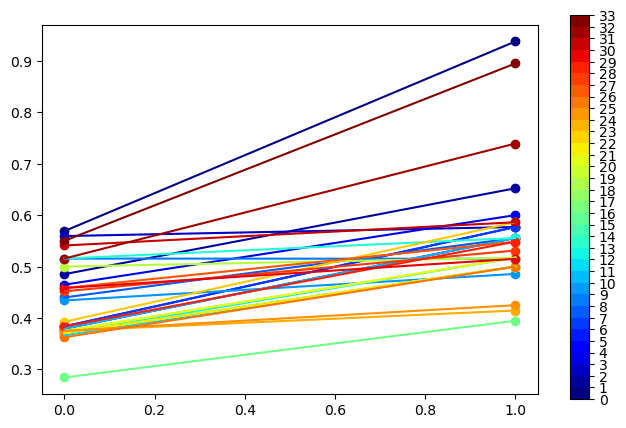

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
for k,v in node_metrics.items():
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,2],color = colors[k])
    ax1.plot(depths,metrics[:,2],color = colors[k])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
plt.show()

In [14]:
#closeness centrality mostly increases across the board

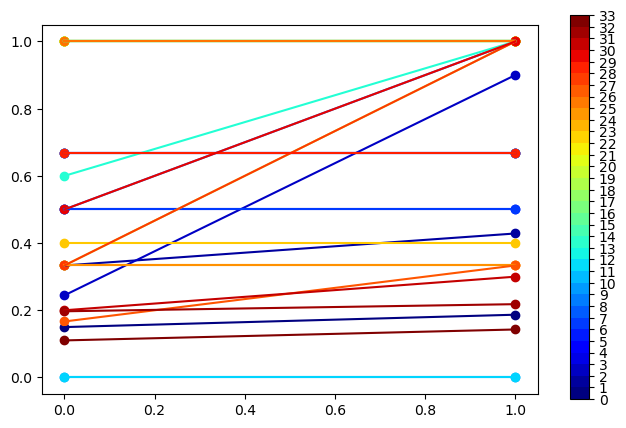

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
for k,v in node_metrics.items():
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,3],color = colors[k])
    ax1.plot(depths,metrics[:,3],color = colors[k])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
plt.show()

In [16]:
#clustering remains same for one group and increases for the other

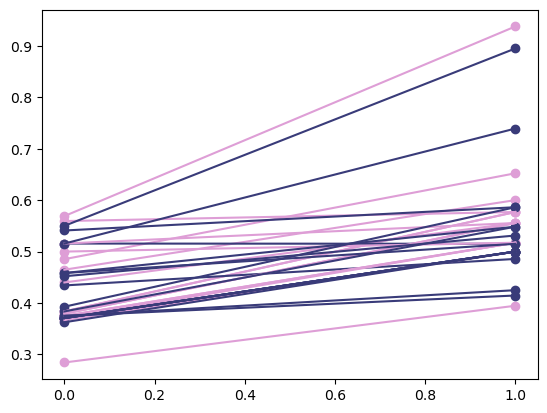

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0,1,2)]
for k,v in node_metrics.items():
    if k in final_communities[0]:
        col = colors[0]
    else:
        col = colors[1]
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,0],color = col)
    ax1.plot(depths,metrics[:,0],color = col)
plt.show()

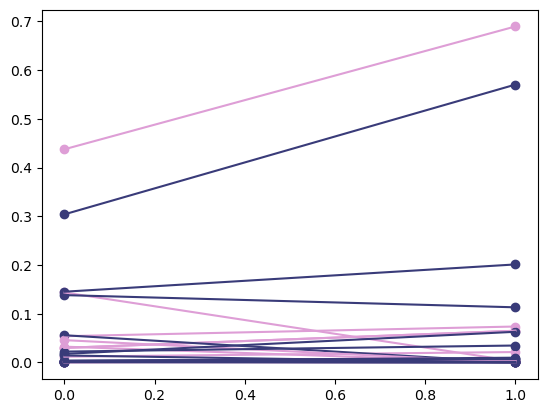

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0,1,2)]
for k,v in node_metrics.items():
    if k in final_communities[0]:
        col = colors[0]
    else:
        col = colors[1]
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,1],color = col)
    ax1.plot(depths,metrics[:,1],color = col)
plt.show()

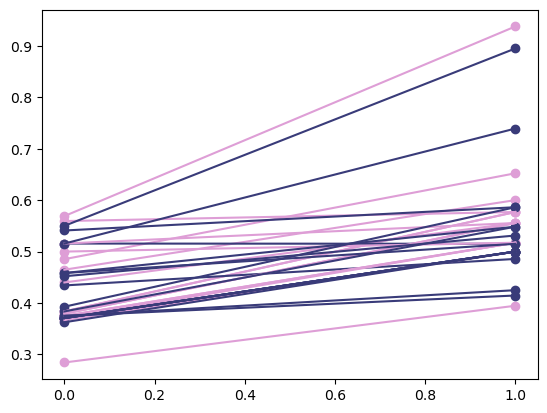

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0,1,2)]
for k,v in node_metrics.items():
    if k in final_communities[0]:
        col = colors[0]
    else:
        col = colors[1]
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,2],color = col)
    ax1.plot(depths,metrics[:,2],color = col)
plt.show()

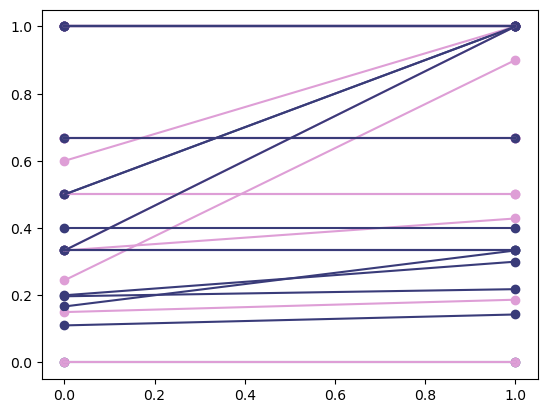

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0,1,2)]
for k,v in node_metrics.items():
    if k in final_communities[0]:
        col = colors[0]
    else:
        col = colors[1]
    depths = list(v.keys())
    metrics = np.array(list(v.values()))
    ax1.scatter(depths,metrics[:,3],color = col)
    ax1.plot(depths,metrics[:,3],color = col)
plt.show()

In [ ]:
#there dosent appear to be any correlation between the final community and change in node metrics